In [1]:
import pandas as pd
import torch
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [2]:
dataset = "IMDB"
n_folds = 5
exp_dir = Path(f"../../results/results_{dataset.lower()}/dipdi")

In [3]:
ratios_A = ["100-0", "75-25", "50-50", "25-75", "0-100"]
ratios_B = ["0-100", "25-75", "50-50", "75-25", "100-0"]

results_dipdi = []
for ratio_A, ratio_B in zip(ratios_A, ratios_B):
    for fold in range(n_folds):
        dipdi = np.load(exp_dir / f"coef_fold_{fold}_{ratio_A} - {ratio_B}.npy")
        results_dipdi.append({"fold": fold, "ratio_A": ratio_A, "ratio_B": ratio_B, "dipdi": dipdi})
df_dipdi = pd.DataFrame(results_dipdi)
df_dipdi["dipdi"] = df_dipdi["dipdi"].astype(float)

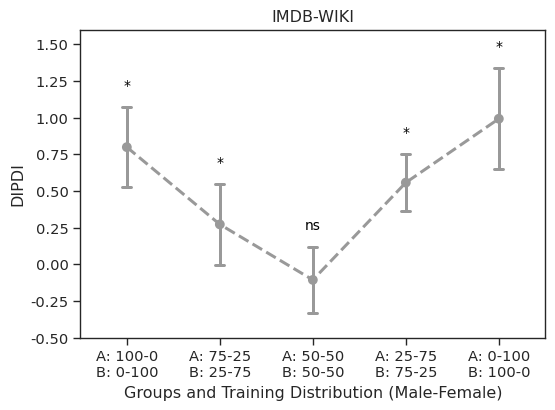

In [4]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
palette_name = "Set1"
colors = sns.color_palette(palette_name)


flierprops = dict(marker="o", markerfacecolor="white")
meanprops = dict(markerfacecolor="red", markeredgecolor="red")
medianprops = dict(linewidth=3)
whiskerprops = dict(linestyle="--", linewidth=1)
plot_params = {"showmeans": True, "width": 0.5, "flierprops": flierprops, "whiskerprops": whiskerprops, "meanprops": meanprops, "medianprops": medianprops,}

ratios_A = df_dipdi["ratio_A"].unique().tolist()
ratios_B = df_dipdi["ratio_B"].unique().tolist()

plt.figure(figsize=(6, 4))
# sns.boxplot(data=df, x="ratio_A", y="dipdi", **plot_params)
#change the width of the line conneccting the means
sns.pointplot(data=df_dipdi, x="ratio_A", y="dipdi", order=ratios_A, linestyles=["--", "-"], markers=["o", "s"], errorbar="sd", capsize=0.1, color=colors[-1])

plt.xlabel("Groups and Training Distribution (Male-Female)")
plt.ylabel("DIPDI")
plt.title(f"{dataset}-WIKI")
plt.ylim(-0.5, 1.6)
# plt.grid(axis="y")

if dataset == "ChestX-ray14":
    plt.ylim(-0.1, 1.0)
elif dataset == "UTKFace":
    plt.ylim(-0.1, 1.5)
elif dataset == "CelebA":
    plt.ylim(-0.3, 2.0)

plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.xticks(ticks=range(len(ratios_A)), labels=[f"A: {ratio_A}\nB: {ratio_B}" for ratio_A, ratio_B in zip(ratios_A, ratios_B)]);
# plt.legend(title="Testing on", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(title="Testing on")

for i, ratio_A in enumerate(ratios_A):
    data_A = df_dipdi[df_dipdi["ratio_A"] == ratio_A]["dipdi"]
    stat, p_value = wilcoxon(data_A, alternative="greater")

    stars = 'ns'
    if p_value < 0.05:
        stars = '*'
    if p_value < 0.01:
        stars = '**'
    if p_value < 0.001:
        stars = '***'

    plt.annotate(stars, xy=(i, 0.1 + data_A.mean() + data_A.std()), ha='center', va='bottom', fontsize=10, color='black')

# sns.despine()
plt.savefig(f"../../results/results_{dataset.lower()}/dipdi_ratios_{dataset}.png", dpi=300, bbox_inches="tight")

In [5]:
df_ratios = df_dipdi.groupby(["ratio_A", "ratio_B"])["dipdi"].agg(["mean", "std"]).reset_index().round(3)
# df_ratios = df_ratios.iloc[[1, 4, 3, 2, 0], :].round(3)
df_ratios

,ratio_A,ratio_B,mean,std
0,0-100,100-0,0.993,0.346
1,100-0,0-100,0.799,0.271
2,25-75,75-25,0.558,0.196
3,50-50,50-50,-0.106,0.224
4,75-25,25-75,0.273,0.278


In [6]:
df_ratios.to_latex()

'\\begin{tabular}{lllrr}\n\\toprule\n & ratio_A & ratio_B & mean & std \\\\\n\\midrule\n0 & 0-100 & 100-0 & 0.993000 & 0.346000 \\\\\n1 & 100-0 & 0-100 & 0.799000 & 0.271000 \\\\\n2 & 25-75 & 75-25 & 0.558000 & 0.196000 \\\\\n3 & 50-50 & 50-50 & -0.106000 & 0.224000 \\\\\n4 & 75-25 & 25-75 & 0.273000 & 0.278000 \\\\\n\\bottomrule\n\\end{tabular}\n'